In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.ensemble import IsolationForest
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = r"F:\Xai_traderx\data\raw\Reliance_stock_data.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-04-22,236.26902770996094,240.25533572672228,230.62448745703495,230.72331899557935,25598349
3,2010-04-23,239.0034637451172,240.71658789873928,237.20247466511563,237.20247466511563,23235165
4,2010-04-26,235.2806854248047,241.111907532806,233.5785280428701,237.2024537889527,16652152


In [5]:
df = df.drop([0,1])
df.columns = ['Date','Close','High','Low','Open','Volume']
df = df.reset_index(drop=True)
df.head()

,Date,Close,High,Low,Open,Volume
0,2010-04-26,235.2806854248047,241.111907532806,233.5785280428701,237.2024537889527,16652152
1,2010-04-27,233.08436584472656,234.56688298655976,231.7116761906747,233.46872539881485,13970196
2,2010-04-28,223.42056274414062,231.4810437522775,222.26748413588032,231.4810437522775,40110291
3,2010-04-29,227.3300018310547,228.39521552103298,223.83785148211462,224.9030651720929,23447044
4,2010-04-30,227.01156616210938,229.9985484932151,226.22088445067072,228.41719973159704,15821019


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3706 non-null   object
 1   Close   3706 non-null   object
 2   High    3706 non-null   object
 3   Low     3706 non-null   object
 4   Open    3706 non-null   object
 5   Volume  3706 non-null   object
dtypes: object(6)
memory usage: 173.8+ KB


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# object to numerical 
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

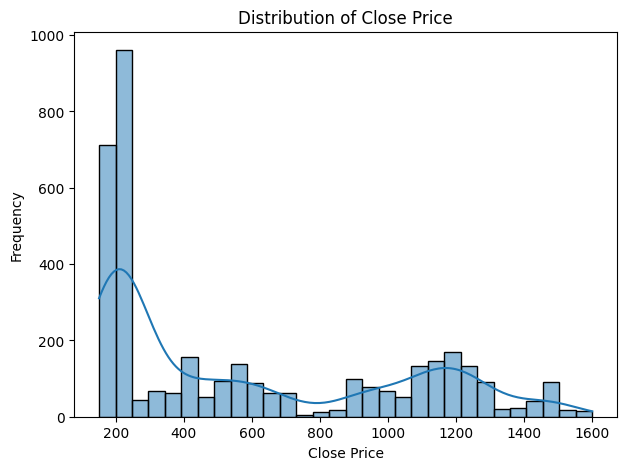

In [8]:
plt.figure(figsize=(7, 5))
sns.histplot(df['Close'], kde=True, bins=30)
plt.title('Distribution of Close Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

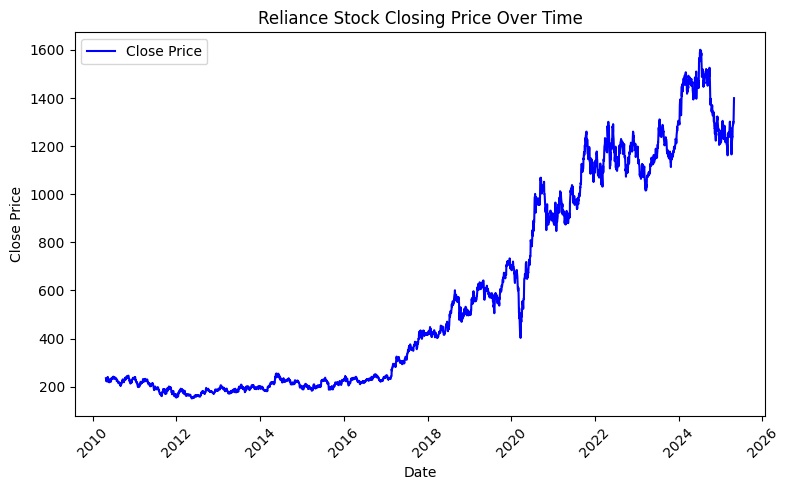

In [9]:
plt.figure(figsize=(8, 5))  
plt.plot(df['Date'], df['Close'], label='Close Price', color='b')
plt.title('Reliance Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout() 
plt.show()

In [10]:
def generate_anomaly_features(df):
    anomaly_df = df.copy()

    # Basic returns
    anomaly_df['Return'] = anomaly_df['Close'].pct_change()

    # Volume ratio
    anomaly_df['volume_ratio'] = anomaly_df['Volume'] / anomaly_df['Volume'].rolling(window=20).mean()

    # Price gap
    anomaly_df['price_gap'] = anomaly_df['Open'] - anomaly_df['Close'].shift(1)

    # Return volatility
    anomaly_df['return_volatility'] = anomaly_df['Return'].rolling(window=20).std()

    # Return z-score
    anomaly_df['return_zscore'] = (anomaly_df['Return'] - anomaly_df['Return'].rolling(window=50).mean()) / anomaly_df['Return'].rolling(window=50).std()

    # Bollinger %B
    rolling_mean = anomaly_df['Close'].rolling(20).mean()
    rolling_std = anomaly_df['Close'].rolling(20).std()
    anomaly_df['Bollinger_%B'] = (anomaly_df['Close'] - (rolling_mean - 2 * rolling_std)) / (4 * rolling_std)

    # Volume Z-score
    anomaly_df['Volume_Z'] = (anomaly_df['Volume'] - anomaly_df['Volume'].rolling(20).mean()) / anomaly_df['Volume'].rolling(20).std()

    # On-Balance Volume (OBV)
    obv = (np.sign(anomaly_df['Close'].diff()) * anomaly_df['Volume']).fillna(0).cumsum()
    anomaly_df['OBV'] = obv

    # RSI
    delta = anomaly_df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    anomaly_df['RSI'] = 100 - (100 / (1 + rs))

    # MACD Histogram
    ema12 = anomaly_df['Close'].ewm(span=12).mean()
    ema26 = anomaly_df['Close'].ewm(span=26).mean()
    anomaly_df['MACD_Hist'] = ema12 - ema26

    # ATR
    high_low = anomaly_df['High'] - anomaly_df['Low']
    high_close = np.abs(anomaly_df['High'] - anomaly_df['Close'].shift())
    low_close = np.abs(anomaly_df['Low'] - anomaly_df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    anomaly_df['ATR'] = tr.rolling(14).mean()

    # Drop rows with NaNs generated due to rolling calculations
    anomaly_df.dropna(inplace=True)

    return anomaly_df

In [11]:
df = generate_anomaly_features(df)

In [12]:
df.head()

,Date,Close,High,Low,Open,Volume,Return,volume_ratio,price_gap,return_volatility,return_zscore,Bollinger_%B,Volume_Z,OBV,RSI,MACD_Hist,ATR
50,2010-07-05,236.368454,237.441548,235.129423,236.744594,6399512,-0.000608,0.363341,0.232311,0.014192,-0.046613,0.613672,-1.468308,59681519.0,50.653602,2.500278,4.943505
51,2010-07-06,237.607498,239.377545,235.748936,235.748936,9255011,0.005242,0.534528,-0.619518,0.013793,0.251224,0.659524,-1.026802,68936530.0,54.811469,2.429610,4.925331
52,2010-07-07,233.104904,237.806606,232.540701,237.629606,13738578,-0.018950,0.796940,0.022108,0.014588,-1.116179,0.346103,-0.444404,55197952.0,44.830592,1.992961,5.000401
53,2010-07-08,233.890381,236.645021,233.481053,234.532022,11977911,0.003370,0.698832,1.427117,0.014525,0.149360,0.316709,-0.650717,67175863.0,50.863967,1.689917,4.632957
54,2010-07-09,234.012070,235.859554,233.104914,235.405991,12974909,0.000520,0.780525,1.515610,0.012887,-0.013583,0.303667,-0.465002,80150772.0,47.304596,1.442814,4.555517


In [13]:
print(df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'volume_ratio', 'price_gap', 'return_volatility', 'return_zscore',
       'Bollinger_%B', 'Volume_Z', 'OBV', 'RSI', 'MACD_Hist', 'ATR'],
      dtype='object')


In [14]:
model_df = df.copy()
features = ['Close', 'Volume_Z', 'return_zscore', 'RSI', 'ATR', 'Bollinger_%B']
fe= ['Volume_Z', 'return_zscore', 'Bollinger_%B'] # after checking feature importance

X = model_df[fe]
# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
# Train Isolation Forest
model = IsolationForest(contamination=0.05, n_estimators=200, random_state=42)
model.fit(X_scaled)

IsolationForest(contamination=0.05, n_estimators=200, random_state=42)

In [15]:
pred = model.predict(X_scaled)
anomaly_score = model.decision_function(X_scaled)

In [16]:
print(pred)
print(anomaly_score)

[ 1  1  1 ...  1 -1  1]
[ 0.11282559  0.15944984  0.14801841 ...  0.16393385 -0.08963405
  0.00019451]


Anomaly score is based on the average path length in the isolation trees: anomalies tend to have shorter paths (they get isolated faster), so they get lower scores.

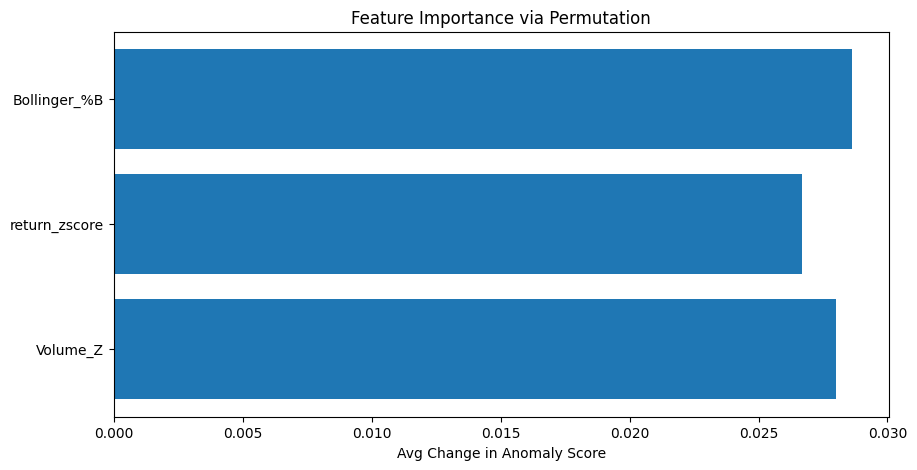

In [17]:
baseline_scores = model.decision_function(X)
importances = []

for col in X.columns:
    X_permuted = X.copy()
    X_permuted[col] = np.random.permutation(X_permuted[col])
    
    permuted_scores = model.decision_function(X_permuted)
    
    # The more the score changes, the more important the feature
    score_diff = np.mean(np.abs(baseline_scores - permuted_scores))
    importances.append(score_diff)

# Plot
plt.figure(figsize=(10,5))
plt.barh(X.columns, importances)
plt.title("Feature Importance via Permutation")
plt.xlabel("Avg Change in Anomaly Score")
plt.show()

In [18]:
norm_df = model_df.copy()
norm_df['anomaly_score'] = model.decision_function(X_scaled)
norm_df['is_anomaly'] = model.predict(X_scaled)

In [19]:
norm_df.head()

,Date,Close,High,Low,Open,Volume,Return,volume_ratio,price_gap,return_volatility,return_zscore,Bollinger_%B,Volume_Z,OBV,RSI,MACD_Hist,ATR,anomaly_score,is_anomaly
50,2010-07-05,236.368454,237.441548,235.129423,236.744594,6399512,-0.000608,0.363341,0.232311,0.014192,-0.046613,0.613672,-1.468308,59681519.0,50.653602,2.500278,4.943505,0.112826,1
51,2010-07-06,237.607498,239.377545,235.748936,235.748936,9255011,0.005242,0.534528,-0.619518,0.013793,0.251224,0.659524,-1.026802,68936530.0,54.811469,2.429610,4.925331,0.159450,1
52,2010-07-07,233.104904,237.806606,232.540701,237.629606,13738578,-0.018950,0.796940,0.022108,0.014588,-1.116179,0.346103,-0.444404,55197952.0,44.830592,1.992961,5.000401,0.148018,1
53,2010-07-08,233.890381,236.645021,233.481053,234.532022,11977911,0.003370,0.698832,1.427117,0.014525,0.149360,0.316709,-0.650717,67175863.0,50.863967,1.689917,4.632957,0.173881,1
54,2010-07-09,234.012070,235.859554,233.104914,235.405991,12974909,0.000520,0.780525,1.515610,0.012887,-0.013583,0.303667,-0.465002,80150772.0,47.304596,1.442814,4.555517,0.175849,1


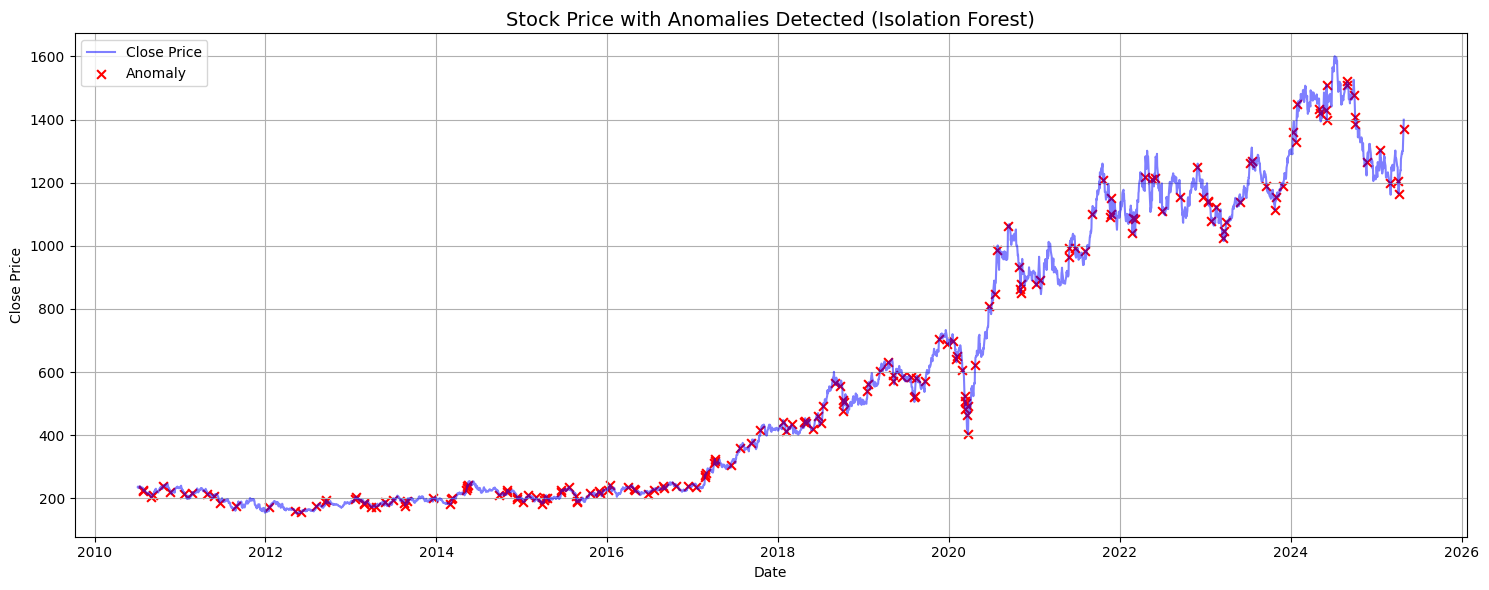

In [20]:
df_plot = norm_df.copy()
df_plot['Date'] = pd.to_datetime(df_plot['Date'])

# Separate anomalies and normal points
anomalies = df_plot[df_plot['is_anomaly'] == -1]
normal = df_plot[df_plot['is_anomaly'] == 1]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df_plot['Date'], df_plot['Close'], label='Close Price', color='blue', alpha=0.5)
plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='Anomaly', s=40, marker='x')
plt.title('Stock Price with Anomalies Detected (Isolation Forest)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
print("Total Anomaly Detected :" ,anomalies['Date'].count())

Total Anomaly Detected : 183


#### Validation of Anomaly Detection Model (Isolation Forest)
Confirming Model Accuracy Through Market Events & Volume Ratio Patterns

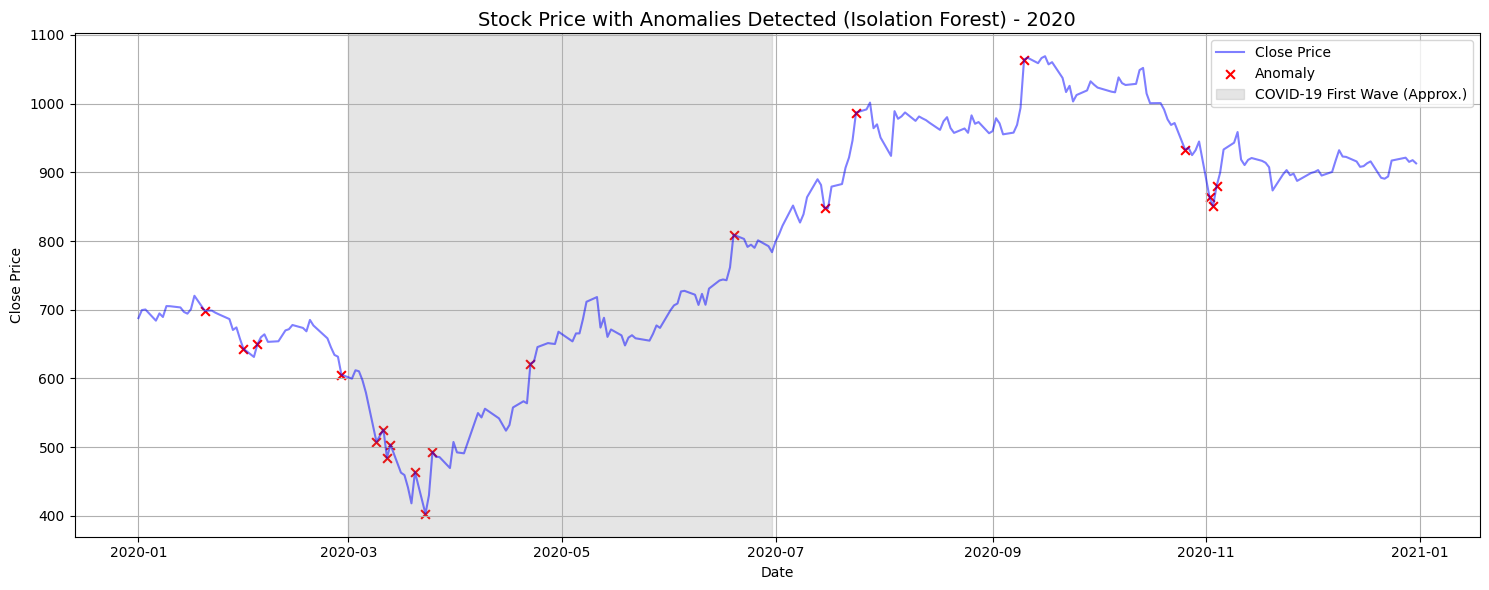

In [22]:
# Filter data for the year 2024 (January to December)
df_plot_2020 = df_plot[(df_plot['Date'].dt.year == 2020)]

# Separate anomalies and normal points
anomalies_20 = df_plot_2020[df_plot_2020['is_anomaly'] == -1]
normal_20 = df_plot_2020[df_plot_2020['is_anomaly'] == 1]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df_plot_2020['Date'], df_plot_2020['Close'], label='Close Price', color='blue', alpha=0.5)
plt.scatter(anomalies_20['Date'], anomalies_20['Close'], color='red', label='Anomaly', s=40, marker='x')

plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-06-30'),
            color='gray', alpha=0.2, label='COVID-19 First Wave (Approx.)')

plt.title('Stock Price with Anomalies Detected (Isolation Forest) - 2020', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

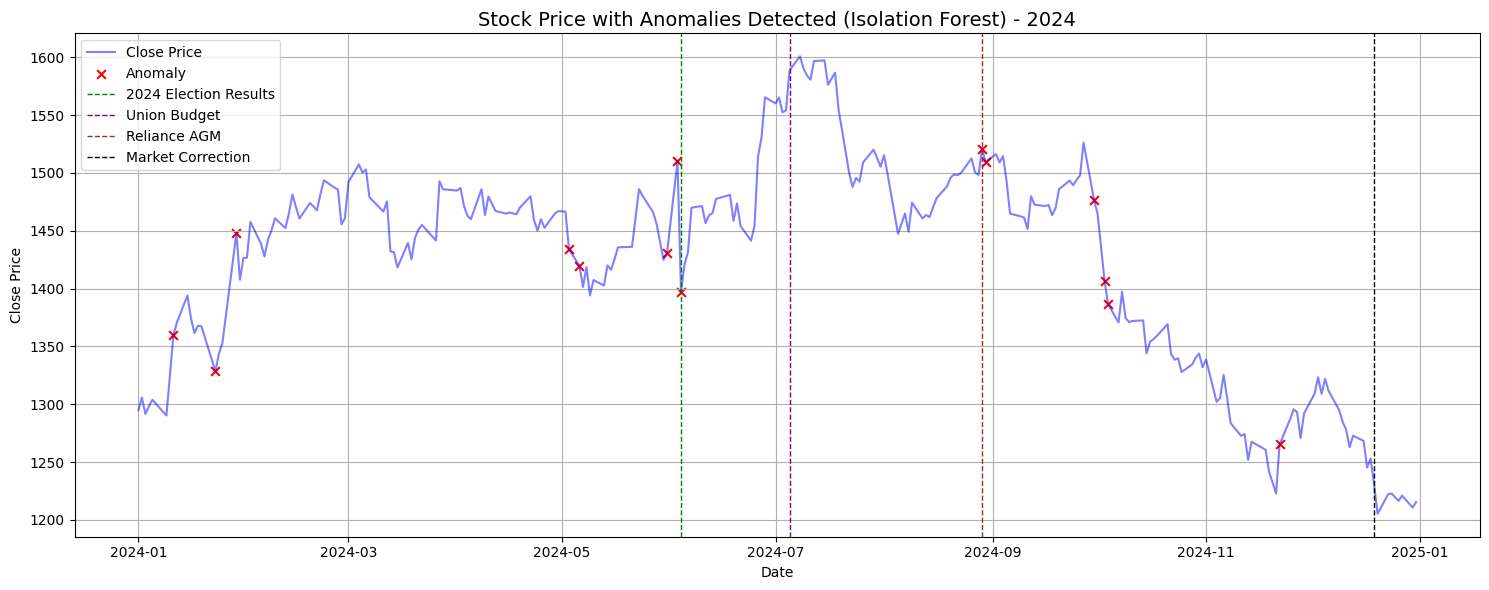

In [23]:
df_plot_2024 = df_plot[(df_plot['Date'].dt.year == 2024)]

# Separate anomalies and normal points
anomalies_24 = df_plot_2024[df_plot_2024['is_anomaly'] == -1]
normal_24 = df_plot_2024[df_plot_2024['is_anomaly'] == 1]

# Define important dates with unique colors
important_dates = {
    'Union Budget': ('2024-07-05', 'purple'),
    'Reliance AGM': ('2024-08-29', 'brown'),
    'Market Correction': ('2024-12-19', 'black')
}

# Start plotting
plt.figure(figsize=(15, 6))

# Plot Close Price and Anomalies
plt.plot(df_plot_2024['Date'], df_plot_2024['Close'], label='Close Price', color='blue', alpha=0.5)
plt.scatter(anomalies_24['Date'], anomalies_24['Close'], color='red', label='Anomaly', s=40, marker='x')

# Election Result - fixed green color
plt.axvline(pd.to_datetime('2024-06-04'), color='green', linestyle='--', linewidth=1, label='2024 Election Results')

# Add each important date with its own color
for label, (date_str, color) in important_dates.items():
    plt.axvline(pd.to_datetime(date_str), color=color, linestyle='--', linewidth=1, label=label)

# Plot formatting
plt.title('Stock Price with Anomalies Detected (Isolation Forest) - 2024', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


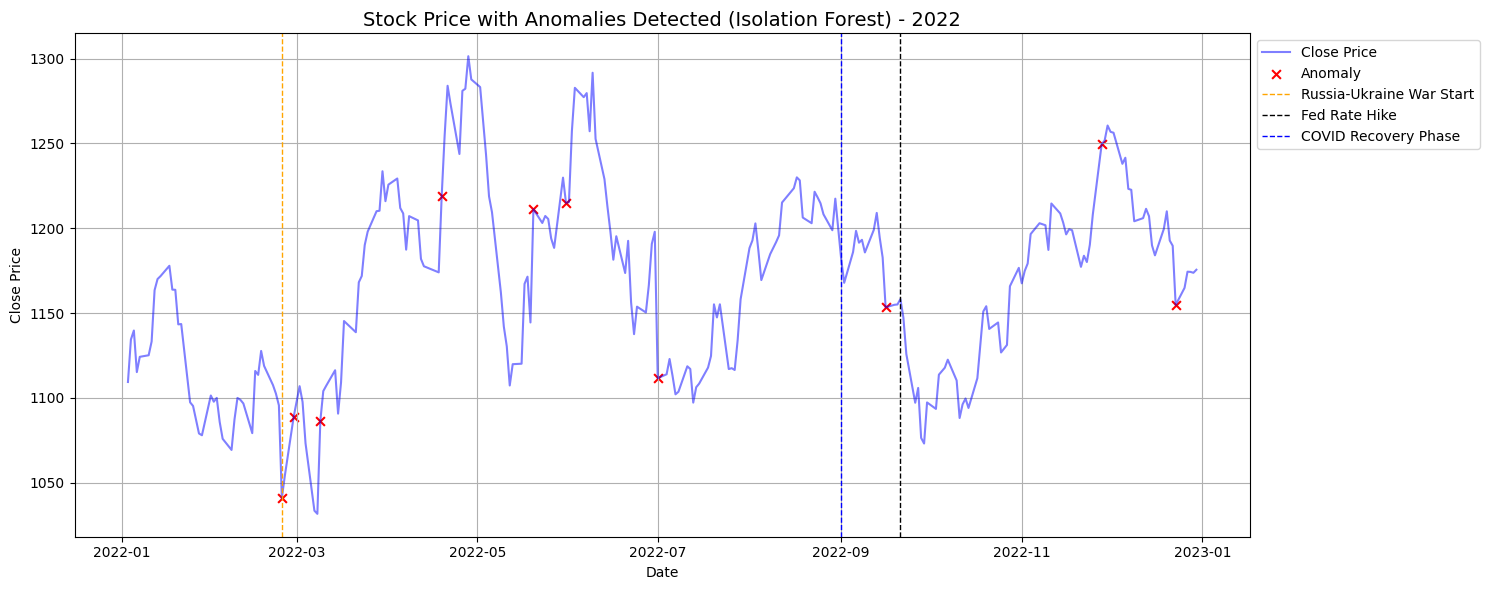

In [24]:
# Filter data for the year 2022 (January to December)
df_plot_2022 = df_plot[(df_plot['Date'].dt.year == 2022)]

# Separate anomalies and normal points for 2022
anomalies_2022 = df_plot_2022[df_plot_2022['is_anomaly'] == -1]
normal_2022 = df_plot_2022[df_plot_2022['is_anomaly'] == 1]

# Define important 2022 dates with unique colors
important_dates_2022 = {
    'Russia-Ukraine War Start': ('2022-02-24', 'orange'),
   
    'Fed Rate Hike ': ('2022-09-21', 'black'),

    'COVID Recovery Phase': ('2022-09-01', 'blue')  # approximate date for recovery phase start
}

# Start plotting
plt.figure(figsize=(15, 6))

# Plot Close Price and Anomalies
plt.plot(df_plot_2022['Date'], df_plot_2022['Close'], label='Close Price', color='blue', alpha=0.5)
plt.scatter(anomalies_2022['Date'], anomalies_2022['Close'], color='red', label='Anomaly', s=40, marker='x')

# Add each important date with its own color
for label, (date_str, color) in important_dates_2022.items():
    plt.axvline(pd.to_datetime(date_str), color=color, linestyle='--', linewidth=1, label=label)

# Plot formatting
plt.title('Stock Price with Anomalies Detected (Isolation Forest) - 2022', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))  # Place legend outside plot for clarity
plt.grid(True)
plt.tight_layout()
plt.show()

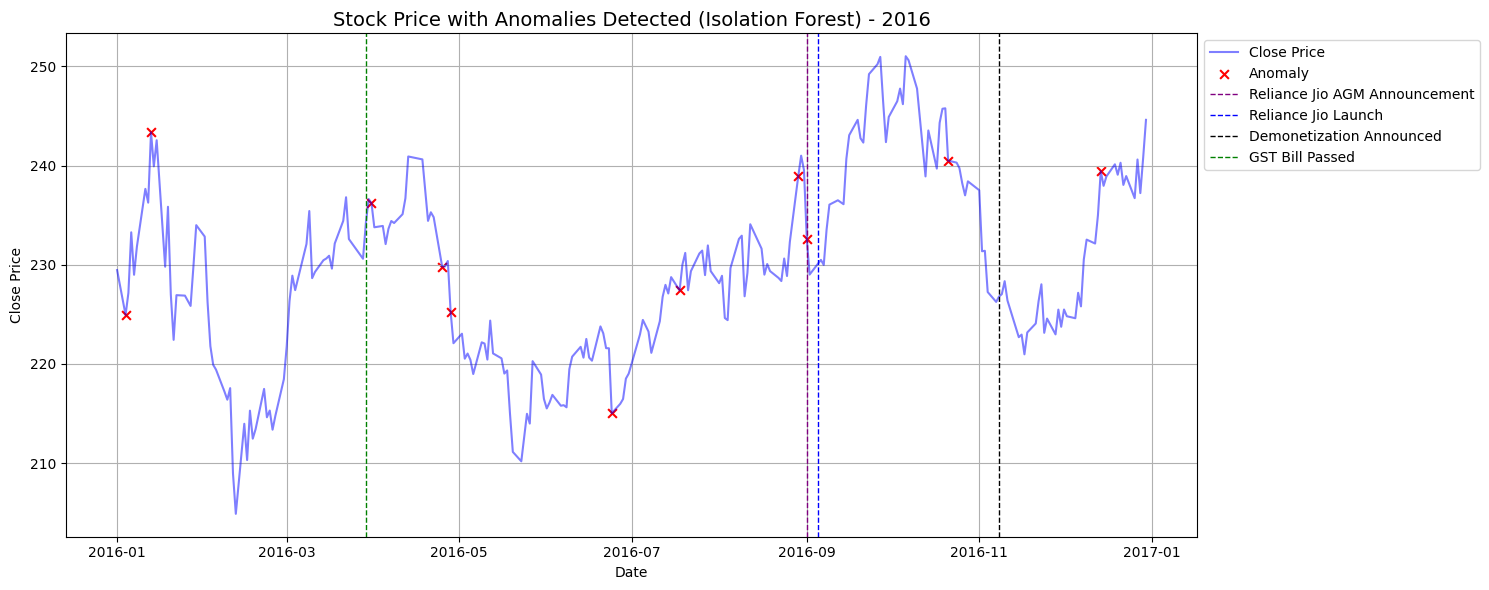

In [25]:
# Filter data for the year 2016 (January to December)
df_plot_2016 = df_plot[(df_plot['Date'].dt.year == 2016)]

# Separate anomalies and normal points for 2016
anomalies_2016 = df_plot_2016[df_plot_2016['is_anomaly'] == -1]
normal_2016 = df_plot_2016[df_plot_2016['is_anomaly'] == 1]

# Define important 2016 dates with unique colors
important_dates_2016 = {
    'Reliance Jio AGM Announcement': ('2016-09-01', 'purple'),
    'Reliance Jio Launch': ('2016-09-05', 'blue'),
    'Demonetization Announced': ('2016-11-08', 'black'),
    'GST Bill Passed': ('2016-03-29', 'green')
}

# Start plotting
plt.figure(figsize=(15, 6))

# Plot Close Price and Anomalies
plt.plot(df_plot_2016['Date'], df_plot_2016['Close'], label='Close Price', color='blue', alpha=0.5)
plt.scatter(anomalies_2016['Date'], anomalies_2016['Close'], color='red', label='Anomaly', s=40, marker='x')

# Add each important date with its own color
for label, (date_str, color) in important_dates_2016.items():
    plt.axvline(pd.to_datetime(date_str), color=color, linestyle='--', linewidth=1, label=label)

# Plot formatting
plt.title('Stock Price with Anomalies Detected (Isolation Forest) - 2016', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))  # Legend outside plot for clarity
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
print("Max volume_ratio:", anomalies['volume_ratio'].max())
print("Min volume_ratio:", anomalies['volume_ratio'].min())

Max volume_ratio: 6.392188977258388
Min volume_ratio: 0.6221497053870818


In [27]:
anomalies = df_plot[df_plot['is_anomaly'] == -1]
print("Anomalies - Volume Ratio:")
print(anomalies['volume_ratio'].describe())

Anomalies - Volume Ratio:
count    183.000000
mean       2.258314
std        0.792521
min        0.622150
25%        1.704189
50%        2.053053
75%        2.746674
max        6.392189
Name: volume_ratio, dtype: float64


In [28]:
file_paths = r"F:\Xai_trader\DeepDive(research)\anomaly news collection.xlsx"
news_df = pd.read_excel(file_paths)

In [29]:
news_df.head()

,DATE,NEWS,NEWS 2
0,2017-02-22 00:00:00,Reliance Industries shares surge to 7-1/2-year...,The Indian stock market closed marginally high...
1,2010-07-28 00:00:00,Shares of Reliance Industries (RIL) were the p...,The Indian stock market closed significantly i...
2,2018-01-22 00:00:00,Both the BSE Sensex and the NSE Nifty reached ...,NaN
3,2023-09-20 00:00:00,oth the BSE Sensex and the NSE Nifty closed si...,NaN
4,2021-05-28 00:00:00,Record High Close: The NSE Nifty reached a new...,NaN
